# Initial setup

In [20]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.models import GeoJSONDataSource, LogColorMapper, LinearColorMapper, HoverTool, Slider, ColorBar, FixedTicker
from bokeh.palettes import OrRd as palette

### Set repo base folder

In [2]:
Base_folder = "/Users/Daniel/Desktop/MSc Data Science/Dissertaton Project/Repo/Vis-EHR"

### Folder settings, import shapefile and data

In [3]:
shapefile_folder = os.path.join(Base_folder, "Shapefile")
shapefilename = "msoa-ref-England-Scotland2011.geojson"
shapefile = os.path.join(shapefile_folder, shapefilename)

covid_data_folder = os.path.join(Base_folder,"Data/Covid Cases data")
date_selected = "07-07-2021"
filename = "England_MSOA_Cases_2021-07-07.csv"
covid_data_path = os.path.join(covid_data_folder, date_selected, filename)

output_file(os.path.join(Base_folder,"Visualisation Dev", "MSOA_covid_cases.html"), title="MSOA Covid Cases", mode='inline')

uk_df = gpd.read_file(shapefile)
covid_data = pd.read_csv(covid_data_path, header=0)

## Custom functions (if required)

## Shapefile plot (and boundaries)

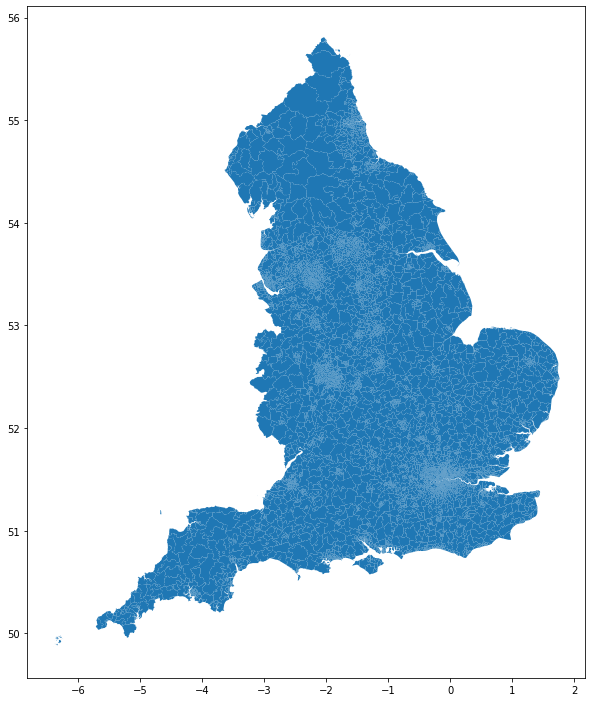

In [5]:
uk_df.plot(figsize=(10, 15))
plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_Shapefile_plot.jpg"))

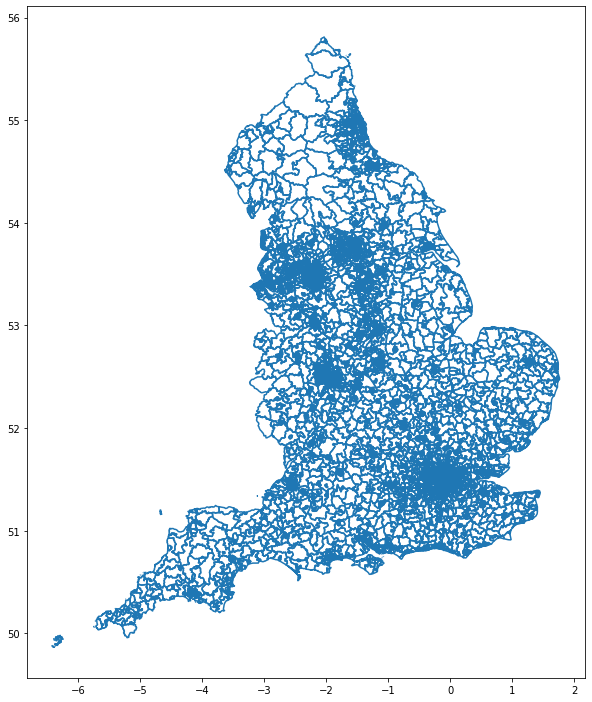

In [4]:
uk_df.boundary.plot(figsize=(10, 15))
plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_Shapefile_boundary.jpg"))

## Data transformations

In [6]:
covid_data.head()

,UtlaCode,UtlaName,LtlaCode,LtlaName,areaCode,areaName,date,newCasesBySpecimenDateRollingSum
0,E08000037,Gateshead,E08000037,Gateshead,E02001682,Ryton,07/07/2021,57
1,E08000037,Gateshead,E08000037,Gateshead,E02001683,Crawcrook & Greenside,07/07/2021,47
2,E08000037,Gateshead,E08000037,Gateshead,E02001684,"Pelaw, Felling Shore & Bill Quay",07/07/2021,67
3,E08000037,Gateshead,E08000037,Gateshead,E02001685,Blaydon South,07/07/2021,85
4,E08000037,Gateshead,E08000037,Gateshead,E02001686,Blaydon North & Winlaton Mill,07/07/2021,77


In [7]:
uk_df.head()

,code,geometry
0,E02000001,"POLYGON ((-0.09274 51.52139, -0.09453 51.52205..."
1,E02000002,"POLYGON ((0.14115 51.58054, 0.14180 51.58531, ..."
2,E02000003,"POLYGON ((0.14841 51.58075, 0.15105 51.58589, ..."
3,E02000004,"POLYGON ((0.19021 51.55268, 0.18475 51.55939, ..."
4,E02000005,"POLYGON ((0.15045 51.56561, 0.15441 51.56607, ..."


In [8]:
uk_df.rename(columns={"code":"areaCode"}, inplace=True) 

In [9]:
df = pd.merge(uk_df,
                  covid_data[["areaCode","areaName","newCasesBySpecimenDateRollingSum"]],
                  on="areaCode")
df.head()

,areaCode,geometry,areaName,newCasesBySpecimenDateRollingSum
0,E02000001,"POLYGON ((-0.09274 51.52139, -0.09453 51.52205...",City of London,39
1,E02000002,"POLYGON ((0.14115 51.58054, 0.14180 51.58531, ...",Marks Gate,11
2,E02000003,"POLYGON ((0.14841 51.58075, 0.15105 51.58589, ...",Chadwell Heath East,14
3,E02000004,"POLYGON ((0.19021 51.55268, 0.18475 51.55939, ...",Eastbrookend,14
4,E02000005,"POLYGON ((0.15045 51.56561, 0.15441 51.56607, ...",Becontree Heath,13


In [10]:
(df["newCasesBySpecimenDateRollingSum"] < 3).sum()

0

## Building Custom plots

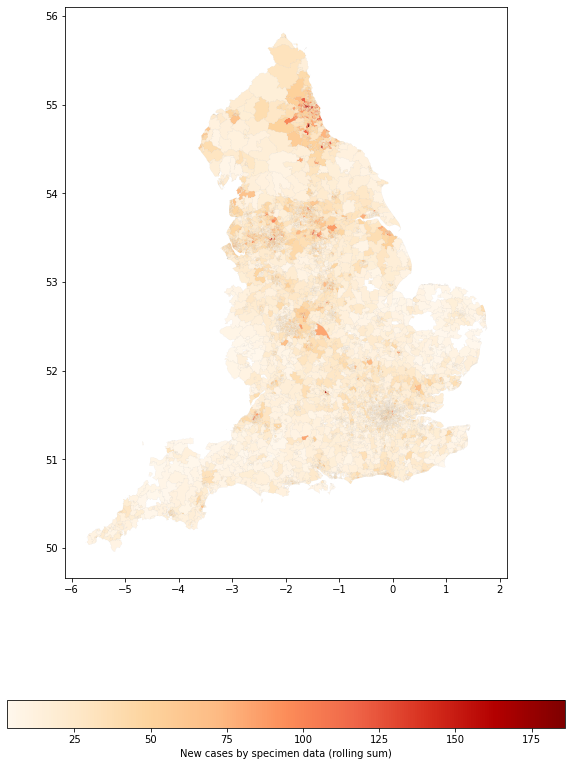

In [11]:
fig, axis = plt.subplots(1,1, figsize=(10,15))
df.plot(column="newCasesBySpecimenDateRollingSum",
            cmap="OrRd",
            figsize=(10, 15),
            ax = axis,
            edgecolor="black",
            linewidth=0.015,
            legend = True,
            legend_kwds={"label": "New cases by specimen data (rolling sum)",
                            "orientation": "horizontal"})

plt.savefig(os.path.join(Base_folder, "Visualisation Dev", "MSOA_covid_cases_7day.jpg"))

In [ ]:
# export to json and read into Bokeh
df_Bokeh = GeoJSONDataSource(geojson=df.to_json())

# Plot 
myplot = figure(title="MSOA cumulative covid cases (2021-07-07)",
               toolbar_location = 'right',
               plot_width= 1200,
               plot_height= 750)

myplot.xgrid.grid_line_color = None
myplot.ygrid.grid_line_color = None
myplot.axis.visible = False

minval = min(covid_data["newCasesBySpecimenDateRollingSum"])
maxval = max(covid_data["newCasesBySpecimenDateRollingSum"])

OrRd_palette = list(reversed(palette[6]))
mypalette = LinearColorMapper(palette=OrRd_palette,
                              low=minval,
                              high=maxval)

mypatch = myplot.patches('xs', 'ys', fill_alpha=1, 
          fill_color={'field': 'newCasesBySpecimenDateRollingSum', 'transform': mypalette}, 
          line_color='black', line_width=0.1, source=df_Bokeh)

myplot.add_tools(HoverTool(renderers=[mypatch],
                          tooltips = [("MSOA name", "@areaName"),
                                      ("Cases", "@newCasesBySpecimenDateRollingSum")]))
num_ticks = 6
tick_diff = (maxval-minval)/num_ticks
tick_vals = [minval, round(minval+tick_diff), round(minval+(2*tick_diff)), round(minval+(3*tick_diff)), round(maxval-(2*tick_diff)), round(maxval-(tick_diff)), maxval]
cb_ticks = FixedTicker(ticks=tick_vals)
color_bar = ColorBar(color_mapper=mypalette, label_standoff=10, ticker=cb_ticks)
myplot.add_layout(color_bar, 'below')

save(myplot)


In [32]:
num_ticks = 6
tick_diff = (maxval-minval)/num_ticks
tick_vals = [minval, round(minval+tick_diff), round(minval+(2*tick_diff)), round(minval+(3*tick_diff)), round(maxval-(2*tick_diff)), round(maxval-(tick_diff)), maxval]
tick_vals

[3, 34, 64, 94, 125, 156, 186]